# Lab02 Part 2: Cost Surface Analysis

By Rob Hendrickson

In [14]:
# Import Libraries

# System

import os # For working with Operating System
import requests # For accessing websites
import urllib # For working with urls
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # Numerical Python
import geopandas as gpd # Spatial Data Manipulation
import rasterio # Working with Rasters
from shapely.geometry import Polygon # For creating shapes

# # Arcpy Stuff

# import arcpy # Arcpy

# # Set Working Directory (Arcpy)

# arcpy.env.workspace = os.getcwd() + 'Arc1_Lab02.gdb'

In [7]:
# Definitions

def extract_zip_from_url(url=None):
    '''Extract a zipfile from the internet and unpack it in to it's own folder within working directory.
    Takes a single url (string).'''
    
    if type(url) == str: # Single url
        # Create folder name for file
        folder_name = url.split('/')[-1][:-4]
        # Make folder for files
        path = os.path.join(os.getcwd(), folder_name)
        if folder_name not in os.listdir():
            os.mkdir(path)
        # Unload zip into the new folder
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall(path=path) # Extract files
        zip_folder.close() # Close zip object
    else:
        print('Error Extracting: Invalid Input')

## Download Data

Attributes:

    - Dory doesn't like:
        - fields in the spring
        - water unless there's a bridge
            - or it's shallow
    - Optimize gradual slope (gradient is low)

Need: Lidar... This includes classifications:

- 2 Ground
- 5  Vegetation
- 6 – Building
- 8 – Model Keypoint (points required to maintain surface integrity).
- 9 – Water
- 10 – Breakline Proximity. Points within 3 meters of a breakline
- 12 – Overlap Points
- 14 – Bridge Decks

I wonder if we can deduce fields by Vegetation??

Start: 44.127985, -92.148796

End: North Picnic Area (about 44.054364, -92.044832)

In Winona, Olmsted, and Wabasha County...

Lidar tiles needed from the `laz` directory found [here](https://resources.gisdata.mn.gov/pub/data/elevation/lidar/county/winona/).
Figured out this list by looking at `tile_index_map.pdf`. They are in UTM 15N (EPSG:26915)

All have this format '4342-tall-wide'

Winona:
* 28 - 31 tall
* 62 - 63 wide

Wabasha
* 28      tall
* 59 - 61 wide

Olmsted
* 29 - 31 tall
* 59 - 61 wide

### Lidar

In [2]:
# Get a list of (county name, tile_name)

counties = ['winona', 'wabasha', 'olmsted']

ranges = [('28,31', '62,63'),
          ('28,28', '59,61'),
          ('29,31', '59,61')]

tile_info = []

for i, county in enumerate(counties):
    
    y_min = int(ranges[i][0].split(',')[0])
    y_max = int(ranges[i][0].split(',')[1])
    
    x_min = int(ranges[i][1].split(',')[0])
    x_max = int(ranges[i][1].split(',')[1])
    
    for y in range(y_min, y_max + 1):
        for x in range(x_min, x_max + 1):
            
            tile_id = '4342-' + str(y) + '-' + str(x)
            tile_info += [(county, tile_id)]

In [3]:
# Download Data

downloaded = True

if not(downloaded):
    # Takes like 5 minutes? Maybe?
    # Total size is 458mb

    base_url = 'https://resources.gisdata.mn.gov/pub/data/elevation/lidar/county/'

    for tile_stuff in tile_info:
        
        county = tile_stuff[0]
        tile_index = tile_stuff[1]

        tile_name = tile_index + '.laz'
        tile_url = base_url + county + '/laz/' + tile_name

        savepath = os.path.join('1_raw_data', 'LazTiles', tile_name)

        if not(os.path.exists(savepath)):

            response = requests.request("GET", tile_url) # Get request

            # Save

            with open(savepath, "wb") as file:
                file.write(response.content)

In [4]:
# Convert Laz to Las

converted_to_las = True

if not(converted_to_las):
    
    # Arcpy Stuff

    import arcpy # Arcpy

    # Set Working Directory (Arcpy)

    arcpy.env.workspace = os.path.join(os.getcwd(), 'Arc1_Lab02_part2.gdb')
    
    # Convert to las

    arcpy.conversion.ConvertLas('Part_2_LazTiles', os.path.join('1_raw_data','LasTiles'),
                                '1.4', 7, 'NO_COMPRESSION',
                                define_coordinate_system = 'ALL_FILES',
                                in_coordinate_system = arcpy.SpatialReference(26915))

### Land Use (Fields)

Minnesota land use found at MN Geocommons

https://gisdata.mn.gov/dataset/biota-landcover-mlccs

Please Create Raster Template before this step

In [8]:
# Download

downloaded = True

if not(downloaded):

    url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_mlccs/shp_biota_landcover_mlccs.zip'

    extract_zip_from_url(url)

In [11]:
# Read

# Get path

folder = url.split('/')[-1][:-4] # Get folder name (last part of address minus .zip)
filename = 'landcover_minnesota_land_cover_classification_system.shp'
path = os.path.join(folder, filename)

landcover = gpd.read_file(path) # Read data to geodataframe

,C_NUM,C_ALPHA,C_TEXT,FLD_CODE,FLD_DATE,FLD_LEVEL,IMG_CODE,IMG_TYPE,M_0XX,M_2XX,...,CARTO,UNIQUE_ID,DATE_INV,EMC,C_FACTOR,RV,ORIG_FID,SHAPE_Leng,SHAPE_Area,geometry
0,61110,6.ge.TG.nMP.,Mesic prairie,0,None,0,0,None,0,0,...,61,None,2002-01-30,0.04,0.002,0.05,2,1140.443850,61486.259881,"POLYGON ((291029.072 4826445.931, 291028.847 4..."
1,61520,6.ge.WC.nME.,Mixed emergent marsh - seasonally flooded,0,None,0,0,None,0,0,...,62,None,2002-01-30,0.03,0.002,0.05,25,268.537811,4379.847387,"POLYGON ((288781.020 4824543.686, 288737.375 4..."
2,22310,2.sv.CS.pUS.,"Upland soils with planted, maintained or culti...",0,None,0,0,None,0,0,...,24,None,2002-01-31,0.32,0.010,0.30,47,756.659907,34221.734858,"POLYGON ((288345.334 4823375.077, 288345.636 4..."


In [30]:
# Clip to extent

# minx = 56495713 miny = 487566062 maxx = 57761522 maxy = 488967939
# These are in centimeters!!!

# Load template raster bounds

# Get bounds from template
rst = rasterio.open('template.tif') # Open template
bounds = rst.bounds
rst.close()

minx, maxy, maxx, miny = bounds

# Create a custom polygon
extent = Polygon([(minx,miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx,miny)])
extent_gdf = gpd.GeoDataFrame([1], geometry=[extent], crs='EPSG:26915')

# Clip

landcover_clipped = landcover.clip(extent_gdf)

/home/robb/miniconda3/envs/gis5571/lib/python3.10/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

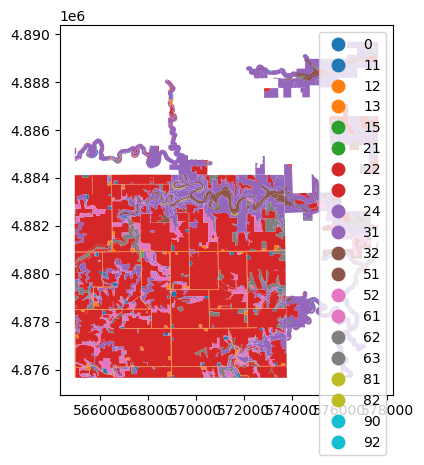

In [36]:
landcover_clipped.plot('CARTO', categorical = True, legend = True)

In [41]:
# Save Fields

landcover_clipped[landcover_clipped.CARTO == 22].to_file(os.path.join('1_raw_data', 'fields.geojson'))